# MATH 693A Advanced Numerical Methods: Computational Optimization HW 5
###  By: Will McGrath


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Problem 1: Implement BFGS

### Below is code which generates initial conditions for the BFGS method. For the initial condition, 18-dimensional initial condition returned by rosenbrock 2Nd(x,-1). 

### Compare against full Newton optimization — count number of “outer iterations” $x_k \rightarrow x_{k+1}$ as well as “inner iterations” (linesearches/backtracking).

In [2]:
def rosenbrock_2Nd(x, order):
    # initial condition in R18
    if order == -1:
        xn = np.array([1, 1])
        x0easy = np.array([1.2, 1.2])
        x0e2 = (xn + x0easy) / 2 
        x0e3 = (xn + x0e2) / 2 
        x0e4 = (xn + x0e3) / 2 
        x0hard = np.array([-1.2, 1])
        x0h2   = (xn + x0hard) / 2
        x0h3   = (xn + x0h2)  / 2
        x0h4   = (xn + x0h3) / 2
        x0h5   = 2 * x0hard

        R = np.array([x0easy, x0e2, x0e3, x0e4, x0hard, x0h2, x0h3, x0h4, x0h5])

        return R

    rb2d = lambda x: 100 * (x[1] - x[0]**2)**2 + (1 - x[0]**2)
    rb2d_x = lambda x: -400 * (x[1] - x[0]**2) * x[0] - 2 + 2 * x[0]
    rb2d_xx = lambda x: 1200 * x[0]**2 - 400 * x[1] + 2
    rb2d_xy = lambda x: -400 * x[0]
    rb2d_y = lambda x: 200 * x[1] - 200 * x[0]**2
    rb2d_yy = lambda x: 200
    rb2d_grad = lambda x: np.array([rb2d_x(x), rb2d_y(x)])
    rb2d_hess = lambda x: np.array([[rb2d_xx(x), rb2d_xy(x)],[rb2d_xy(x), rb2d_yy(x)]])

    # 1D versions
    # the function and derivatives needed to compute the
    # gradient and the hessian
    if order == 0: 
        return rb2d(x)

    elif order == 1:
        return rb2d_grad(x)

    elif order == 2:
        return rb2d_hess(x)

    else:
        print(f'Cannot compute derviates of order {order}')

## Part A, B, C, D, E

## 1A) Present the value of the following in a table for BFGS for each outer iteration:
- Number of iterations
- $f(x)$
- $\alpha$
- $\nabla{f(x_k)}$

## 1B) Total number of outer iterations

## 1C) Total number of inner iterations

## 1D) Repeat 1a, b, and c for Newton method. Discuss your observations

## 1E) Check the Quasi-Newton convergence criteria (from lecture #5)
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$ \lim_{k\to\infty} \frac{\|(B_k - \nabla^2{f(\bar{x_k})})\bar{p_k}\|}{\|\bar{p_k} \|} $
- Present the value of $ \frac{\|(B_k - \nabla^2{f(\bar{x_k})})\bar{p_k}\|}{\|\bar{p_k} \|} $ for each outer iteration in a table 
- Plot $ \log_{10}(\frac{\|(B_k - \nabla^2{f(\bar{x_k})})\bar{p_k}\|}{\|\bar{p_k} \|})$ against iteration


In [3]:
# backtracking = wolfe condition = line search 
def bfgs_method(x0, eps=10**(-4)):
    inner_iter_list, k_list, xk_list, fx_list, alpha_list, grad_list, convergence_list = [], [], [], [], [], [], []
    k = 0
    c = 10**(-2)
    rho = 0.5
    xk = x0
    grad_fk = rosenbrock_2Nd(x0, 1) # grad(x0)
    I = np.eye(len(x0), dtype=int) # identity matrix I
    Hk = I

    while np.linalg.norm(grad_fk) > eps:
        # search direction
        pk = -np.dot(Hk, grad_fk)

        # backtracking 
        # tries to find optimum alpha so doesn't move to far
        inner_iter = 0 
        alpha_k = 1
        while (rosenbrock_2Nd(xk + alpha_k * pk, 0) > rosenbrock_2Nd(xk, 0) + alpha_k * c * np.dot(pk, grad_fk)):
            alpha_k *= rho
            inner_iter += 1
        
        if k == 0:
            inner_iter_list.append(np.nan)
            xk_list.append(x0)
            k_list.append(0)
            fx_list.append(rosenbrock_2Nd(x0, 0))
            alpha_list.append(1)
            grad_list.append(rosenbrock_2Nd(x0, 1))
            convergence_list.append(np.nan)
            
        xkp1 = xk + alpha_k * pk
        sk = xkp1 - xk
        xk = xkp1
        grad_fkp1 = rosenbrock_2Nd(xkp1,1)
        yk = grad_fkp1 - grad_fk
        grad_fk = grad_fkp1
        ro = 1.0 / (np.dot(yk, sk))
        A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
        A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
        Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * sk[:, np.newaxis] * sk[np.newaxis, :])

        num = np.linalg.norm(np.dot((Hk - rosenbrock_2Nd(xk, 2)), pk))
        denom = np.linalg.norm(pk)
        convergence = num / denom

        k += 1
        xk_list.append(xk)
        k_list.append(k)
        fx_list.append(rosenbrock_2Nd(xk, 0))
        alpha_list.append(alpha_k)
        grad_list.append(grad_fk)
        inner_iter_list.append(inner_iter)
        convergence_list.append(convergence)

    bfgs_df = pd.DataFrame([[k_list, inner_iter_list, xk_list, fx_list, alpha_list, grad_list, convergence_list]], 
    columns=['outer_iteration', 'inner_iteration', 'xbar', 'f(x)', 'alpha', 'grad_f(x)', 'Quasi_Newton_Convergence']).explode(
        ['outer_iteration', 'inner_iteration', 'xbar', 'f(x)', 'alpha', 'grad_f(x)', 'Quasi_Newton_Convergence']).reset_index(drop=True)

    bfgs_df = bfgs_df[:-1]
    return bfgs_df

In [4]:
rosenbrock_2Nd(0, -1)

array([[ 1.2  ,  1.2  ],
       [ 1.1  ,  1.1  ],
       [ 1.05 ,  1.05 ],
       [ 1.025,  1.025],
       [-1.2  ,  1.   ],
       [-0.1  ,  1.   ],
       [ 0.45 ,  1.   ],
       [ 0.725,  1.   ],
       [-2.4  ,  2.   ]])

### $x_0 = [1.2, 1.2]$

In [5]:
bfgs_df_1 = bfgs_method([1.2, 1.2])
bfgs_df_1

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[1.2, 1.2]",5.32,1,"[115.6, -48.0]",NaN
1,1,10,"[1.087109375, 1.246875]",0.24158,0.000977,"[-28.120284295082076, 13.013641357421875]",1124.516646
2,2,2,"[0.9959647725949852, 1.0166730224733447]",0.069198,0.25,"[-9.85903620336432, 4.945438844632832]",90.147544
3,3,50,"[0.995964772594985, 1.016673022473344]",0.069198,0.0,"[-9.859036203364228, 4.945438844632804]",66.231078
4,4,9,"[0.9787745049103602, 0.9607287052276449]",0.042745,0.001953,"[-1.1109492704887334, 0.5458347530248204]",167.221487
5,5,46,"[0.9787745049103602, 0.9607287052276448]",0.042745,0.0,"[-1.1109492704886899, 0.545834753024792]",165.627008
6,6,0,"[0.9792812470037081, 0.9593724870540806]",0.041023,1,"[-0.1905727645287023, 0.0761452641886251]",714.072067
7,7,0,"[0.9794432981252615, 0.9592645587548139]",0.040691,1,"[-0.023634067590701635, -0.008923097535245006]",962.491806
8,8,0,"[0.9795314713651537, 0.9594038896777732]",0.040519,1,"[-0.010370300865993665, -0.015602743401956332]",90.082775
9,9,0,"[0.9816585445851176, 0.9631652680251315]",0.03637,1,"[0.15502720142803827, -0.09764602636795416]",43.240794


In [18]:
bfgs_df_1['inner_iteration'].sum()

153

### Total number of outer iterations: 16

### Total number of inner iterations: 153

### Minimum: $x^* = [1,1]$

### $x_0 = [1.1, 1.1]$

In [6]:
bfgs_df_2 = bfgs_method([1.1, 1.1])
bfgs_df_2

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[1.1, 1.1]",1.0,1,"[48.60000000000005, -22.0]",NaN
1,1,10,"[1.0525390625, 1.121484375]",-0.089217,0.000977,"[-5.640057691931821, 2.7291793823242756]",1083.240983
2,2,46,"[1.0525390624999993, 1.121484374999998]",-0.089217,0.0,"[-5.640057691931539, 2.7291793823241335]",59.658473
3,3,0,"[1.0678823355931206, 1.1399419201827405]",-0.140354,1,"[0.31976613235516727, -0.08615249781556145]",282.494233
4,4,47,"[1.0678823355931206, 1.1399419201827403]",-0.140354,0.0,"[0.3197661323552621, -0.08615249781558987]",20.959287
5,5,47,"[1.0678823355931206, 1.1399419201827403]",-0.140354,0.0,"[0.3197661323552621, -0.08615249781558987]",NaN


In [19]:
bfgs_df_2['inner_iteration'].sum()

150

### Total number of outer iterations: 6

### Total number of inner iterations: 150

### Minimum: $x^* = [1,1]$

### $x_0 = [1.05, 1.05]$

In [7]:
bfgs_df_3 = bfgs_method([1.05, 1.05])
bfgs_df_3

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[1.05, 1.05]",0.173125,1,"[22.15, -10.5]",NaN
1,1,10,"[1.028369140625, 1.06025390625]",-0.056808,0.000977,"[-1.0583498807158542, 0.5421633720397949]",1046.726611
2,2,47,"[1.028369140625, 1.0602539062499998]",-0.056808,0.0,"[-1.0583498807157627, 0.5421633720397665]",41.436149
3,3,51,"[1.028369140625, 1.0602539062499996]",-0.056808,0.0,"[-1.0583498807156713, 0.5421633720397097]",160.513143
4,4,0,"[1.0628075971998705, 1.1135604716281517]",-0.103962,1,"[6.927378498040172, -3.199903407522072]",151.42084
5,5,48,"[1.0628075971998703, 1.1135604716281515]",-0.103962,0.0,"[6.927378498040075, -3.199903407522015]",143.716625
6,6,46,"[1.062807597199869, 1.1135604716281498]",-0.103962,0.0,"[6.927378498039592, -3.1999034075218162]",155.797126
7,7,0,"[1.0512454226495713, 1.1032990340239257]",-0.104786,1,"[0.8669164085885182, -0.363580923550046]",424.97584
8,8,45,"[1.0512454226495713, 1.1032990340239257]",-0.104786,0.0,"[0.8669164085885182, -0.363580923550046]",NaN


In [20]:
bfgs_df_3['inner_iteration'].sum()

247

### Total number of outer iterations: 9

### Total number of inner iterations: 247

### Minimum: $x^* = [1,1]$

### $x_0 = [1.025, 1.025]$

In [8]:
bfgs_df_4= bfgs_method([1.025, 1.025])
bfgs_df_4

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[1.025, 1.025]",0.015039,1,"[10.556250000000002, -5.125]",NaN
1,1,10,"[1.0146911621093748, 1.0300048828125]",-0.029582,0.000977,"[-0.13569914047930398, 0.08134566992524128]",1025.14282
2,2,46,"[1.0146911621093748, 1.0300048828124997]",-0.029582,0.0,"[-0.13569914047921383, 0.08134566992521286]",15.200861
3,3,48,"[1.0146911621093748, 1.0300048828124995]",-0.029582,0.0,"[-0.13569914047912368, 0.08134566992515602]",157.463685
4,4,0,"[1.0159786200600012, 1.0317289541329258]",-0.032189,1,"[0.22848907343531355, -0.09672045721970335]",188.936122
5,5,45,"[1.0159786200600012, 1.0317289541329258]",-0.032189,0.0,"[0.22848907343531355, -0.09672045721970335]",NaN


In [21]:
bfgs_df_4['inner_iteration'].sum()

149

### Total number of outer iterations: 6

### Total number of inner iterations: 149

### Minimum: $x^* = [1,1]$

### $x_0 = [-1.2, 1]$

In [9]:
bfgs_df_5 = bfgs_method([-1.2, 1])
bfgs_df_5

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[-1.2, 1]",18.92,1,"[-215.59999999999997, -88.0]",NaN
1,1,10,"[-0.989453125, 1.0859375]",1.164171,0.000977,"[38.338030314445454, 21.384002685546847]",946.505385
2,2,3,"[-0.7723458059823386, 0.5705923983388312]",0.470696,0.125,"[-11.55411709519772, -5.185129135935384]",114.413891
3,3,50,"[-0.7723458059823386, 0.5705923983388312]",0.470696,0.0,"[-11.55411709519772, -5.185129135935384]",NaN


In [22]:
bfgs_df_5['inner_iteration'].sum()

63

### Total number of outer iterations: 4

### Total number of inner iterations: 63

### Minimum: $x^* = [1,1]$

### $x_0 = [-0.1, 1]$

In [10]:
bfgs_df_6 = bfgs_method([-0.1, 1])
bfgs_df_6

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[-0.1, 1]",99.0,1,"[37.4, 198.0]",NaN
1,1,7,"[-0.3921875, -0.546875]",49.942281,0.007812,"[-112.70449676513672, -140.13720703125]",321.845055
2,2,7,"[-0.04338358775090512, -0.6959452879456169]",49.694429,0.007812,"[-14.196470082748366, -139.56548472635149]",260.709209
3,3,0,"[-0.20892457746579182, 0.09785536936239136]",1.250178,1,"[2.112127935328261, 10.841178058626344]",195.282522
4,4,0,"[-0.20030948806018697, 0.042029447859687326]",0.960239,1,"[-2.2479385290625493, 0.38111137055062727]",199.692597
5,5,46,"[-0.20030948806018684, 0.042029447859687215]",0.960239,0.0,"[-2.2479385290625538, 0.3811113705506166]",70.424936
6,6,51,"[-0.20030948806018675, 0.042029447859687166]",0.960239,0.0,"[-2.2479385290625546, 0.38111137055061306]",39.005833
7,7,53,"[-0.20030948806018672, 0.04202944785968715]",0.960239,0.0,"[-2.2479385290625546, 0.38111137055061306]",NaN


In [23]:
bfgs_df_6['inner_iteration'].sum()

164

### Total number of outer iterations: 8

### Total number of inner iterations: 164

### Minimum: $x^* = [1,1]$

### $x_0 = [0.45, 1]$

In [11]:
bfgs_df_7 = bfgs_method([0.45, 1])
bfgs_df_7

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[0.45, 1]",64.398125,1,"[-144.65, 159.5]",NaN
1,1,8,"[1.0150390625, 0.376953125]",42.656471,0.003906,"[265.3008631378413, -130.6702346801758]",1114.0045
2,2,6,"[0.5685647274405503, -0.24136728730428314]",32.557792,0.015625,"[127.54932361943078, -112.9266273187661]",104.496177
3,3,0,"[0.7755648980723641, 0.6399221006423631]",0.546118,1,"[-12.368120577528133, 7.684237904073328]",230.985271
4,4,0,"[0.7765599719813459, 0.6061556066891216]",0.397922,1,"[-1.4129879440318964, 0.6220433210905867]",386.199411
5,5,0,"[0.7784937442076751, 0.6059820744761159]",0.393948,1,"[-0.42107913716950085, -0.014087058873840874]",608.700365
6,6,0,"[0.7818146460983141, 0.6098841130018432]",0.388948,1,"[-0.014182088873144316, -0.2700055703977853]",94.881824
7,7,0,"[0.8019604378595756, 0.6376140091214572]",0.359914,1,"[1.3767457734664803, -1.1053069540930096]",52.632624
8,8,0,"[0.8266998613728145, 0.6753205671623603]",0.323148,1,"[2.335906394977565, -1.622418726294086]",29.864102
9,9,0,"[0.8610673247717731, 0.732517233079648]",0.266519,1,"[2.794321158490786, -1.7839409419940182]",14.363132


In [24]:
bfgs_df_7['inner_iteration'].sum()

14

### Total number of outer iterations: 17

### Total number of inner iterations: 14

### Minimum: $x^* = [1,1]$

### $x_0 = [0.725, 1]$

In [12]:
bfgs_df_8 = bfgs_method([0.725, 1])
bfgs_df_8

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[0.725, 1]",22.977539,1,"[-138.11875, 94.875]",NaN
1,1,9,"[0.99476318359375, 0.814697265625]",3.067927,0.001953,"[69.56586008137893, -34.971305161714554]",1035.798244
2,2,4,"[0.749587748465379, 0.4346999069211106]",2.055641,0.0625,"[37.63276884438948, -25.436377145657133]",21.101264
3,3,0,"[0.8521387548108207, 0.7320954387449032]",0.277406,1,"[-2.3255106284198845, 1.1909962588734402]",154.149342
4,4,0,"[0.8562834796302594, 0.7339695463152802]",0.266835,1,"[-0.5436840332824877, 0.14962976551507268]",456.847468
5,5,0,"[0.8634696912047775, 0.7443708647180416]",0.254566,1,"[0.144528146095531, -0.24180858224642066]",64.627711
6,6,0,"[0.8886957376934026, 0.7849503181663695]",0.212553,1,"[1.4942791330099834, -0.9659592056103179]",38.133204
7,7,0,"[0.9089436594072459, 0.8206145981410247]",0.176917,1,"[1.8408242687188066, -1.1127955671221343]",13.398653
8,8,0,"[0.9442939503048142, 0.8876026675587954]",0.10998,1,"[1.432847330894528, -0.8176794046951272]",0.409181
9,9,0,"[0.9643181880467038, 0.9292561705705612]",0.070133,1,"[0.18066950814460125, -0.13067944542336818]",27.702639


In [25]:
bfgs_df_8['inner_iteration'].sum()

13

### Total number of outer iterations: 14

### Total number of inner iterations: 13

### Minimum: $x^* = [1,1]$

### $x_0 = [-2.4, 2]$

In [13]:
bfgs_df_9 = bfgs_method([-2.4, 2])
bfgs_df_9

,outer_iteration,inner_iteration,xbar,f(x),alpha,grad_f(x),Quasi_Newton_Convergence
0,0,NaN,"[-2.4, 2]",1409.0,1,"[-3616.4, -752.0]",NaN
1,1,10,"[1.1316406250000002, 2.734375]",211.06251,0.000977,"[-657.7923038244247, 290.7528991699218]",528.995794
2,2,9,"[1.4587270852793486, 1.8102823635100564]",8.95924,0.001953,"[186.23551184747302, -63.52046916350554]",1222.723845
3,3,0,"[1.3807032844235694, 1.9620286102433582]",-0.596237,1,"[-29.993510910452645, 11.13741012506523]",1255.346271
4,4,0,"[1.3911575419023532, 1.9383237575792043]",-0.934417,1,"[-0.8895508876506599, 0.6008902374813374]",1205.213245
5,5,0,"[1.3913512332085232, 1.9366242946895296]",-0.9358,1,"[0.35636988716092466, 0.15320810773027915]",774.113047
6,6,42,"[1.3913512332085232, 1.9366242946895293]",-0.9358,0.0,"[0.35636988716104856, 0.1532081077302223]",210.91156
7,7,42,"[1.3913512332085232, 1.9366242946895291]",-0.9358,0.0,"[0.356369887161172, 0.1532081077302223]",NaN


In [26]:
bfgs_df_9['inner_iteration'].sum()

103

### Total number of outer iterations: 8

### Total number of inner iterations: 103

### Minimum: $x^* = [1,1]$

In [14]:
# log plots
def plot_logy(all_df):
    plt.figure(figsize=(15, 9))
    for df in all_df:
        xbar_list = df['xbar'].to_list()
        converg_list = np.ma.log10(df['Quasi_Newton_Convergence'].to_list()).data
        indx_list = np.linspace(1, len(xbar_list), len(xbar_list))
        plt.plot(indx_list, converg_list)

    plt.xlabel('Iteration')
    plt.ylabel('Log of Quasi Newton Convergence')
    plt.title('Algorithm Convergence')
    plt.xticks(np.arange(0,21))
    plt.legend(["x0 = [1.2, 1.2]", "x0 = [1.1, 1.1]", "x_0 = [1.05, 1.05]", 
                "x_0 = [1.025, 1.025]", "x_0 = [-1.2, 1]", "x_0 = [-0.1, 1]",
                "x_0 = [0.45, 1]", "x_0 = [0.725, 1]", "x_0 = [-2.4, 2]"], loc=0)

    return None

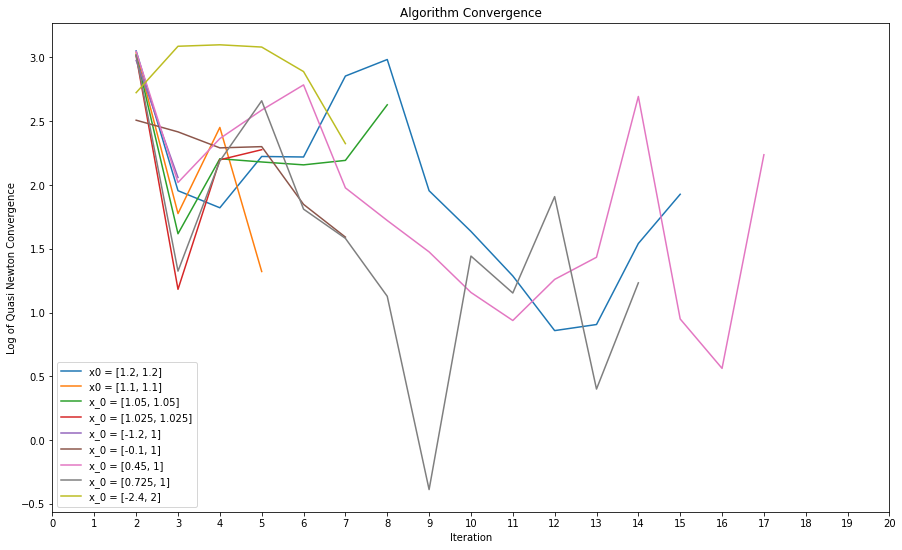

In [15]:
all_df = [bfgs_df_1, bfgs_df_2, bfgs_df_3, bfgs_df_4, bfgs_df_5, bfgs_df_6, bfgs_df_7, bfgs_df_8, bfgs_df_9]
plot_logy(all_df)

# Problem 2
### Construct matrices with different eigenvalue distributions (clustered and non- clustered) and apply the Conjugate Gradient (CG) method to them. Comment on whether the behavior can be explained from Theorem 5.5 in the text by Nocedal and Wright 2006. Generate a figure similar to Figure 5.4 in the text by Nocedal and Wright 2006.

In [16]:
# congujate gradient method
def linear_conjugate_gradient(A, b, x0, stopping_criteria = 10**(-6)):
    xk = x0
    rk = np.dot(A, xk) - b # residuals
    pk = -rk
    k = 0 # count 
    xk_list, rk_norm_list, residual_list, iteration_list = [], [], [], []

    while np.linalg.norm(rk) > stopping_criteria:
        
        ap_k = np.dot(A, pk) 
        rk_rk = np.dot(rk, rk)
        alpha = rk_rk / np.dot(pk, ap_k)

        if k == 0:
            iteration_list.append(k)
            residual_list.append(rk)
            xk_list.append(xk)
            rk_norm_list.append(np.linalg.norm(rk))

        xk = xk + alpha * pk
        rk = rk + alpha * ap_k
        beta = np.dot(rk, rk) / rk_rk
        pk = -rk + beta * pk

        k += 1
        iteration_list.append(k)
        residual_list.append(rk)
        xk_list.append(xk)
        rk_norm_list.append(np.linalg.norm(rk))

    df = pd.DataFrame([[iteration_list, xk_list, residual_list, rk_norm_list]], 
        columns=['iteration', 'xbar', 'residuals', 'norm_residuals']
    ).explode(['iteration', 'xbar', 'residuals', 'norm_residuals']).reset_index(drop=True)

    return df

In [27]:
# hilbert matrix
def hilbert(n):
    matrix = []
    for i in range(1, n + 1):
        row = []
        for j in range(1, n + 1):
            row.append(1 / (i + j - 1))
        matrix.append(row)
        
    return matrix

def bn(n):
    return np.ones(n)

def xn(n):
    return np.zeros(n)